In [1]:
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, widgets, fixed, Layout
import matplotlib.colors as mcolors

In [2]:
# read in the input rasters
# would be way easier to do this in numpy or gdal
# but for sake of completeness, the method in the lecture

def load_raster(file_name):
    raster_list = []
    with open(file_name) as f:
        for line in f:
            split = str.split(line, ",")
            data = []
            for num in split:
                data.append(float(num))
            raster_list.append(data)
    return np.array(raster_list)

mway = load_raster("best.mway.txt")
pop = load_raster("best.pop.txt")
geo = load_raster("best.geology.txt")

In [7]:
# initialie the jupyter widgets, keep the min to 0.1 so the function doesn't error out
geo_dim = widgets.FloatSlider(min=0.1,max=10,value=1, step=0.1,description="Geological Weight:",style={'description_width': 'initial'})
pop_dim = widgets.FloatSlider(min=0.1,max=10,value=1, step=0.1,description="Population Weight:",style={'description_width': 'initial'})
mway_dim = widgets.FloatSlider(min=0.1,max=10,value=1, step=0.1,description="Motorway Weight: ",style={'description_width': 'initial'})
top_percentile = widgets.Checkbox(value=False, description="Highlight Top 10%")
export = widgets.ToggleButton(value=False, description="Export to File")

def mergerize(geo=None, pop=None, mway=None, geo_dim=None, pop_dim=None, mway_dim=None, top_percentile=None, export=None):
    """Main function handling rendering: merges the weighted matrices, handles colormaps and exporting as needed"""
    total = geo * geo_dim + pop * pop_dim + mway * mway_dim
    if total.max() > 0: # can never be zero due to the slider settings, but good to chekc
        total /= total.max()
        total *= 255

    if export:
        with open('waste_export.txt', 'wb') as f:
            # way more efficient than manually looping over each value in the array
            np.savetxt(f, total, delimiter=',', fmt='%1i')

    # construct the gray -> blue colormap
    gray_90 = plt.get_cmap('binary')(np.linspace(0, 0.9, 1000))
    blue_10 = plt.get_cmap('viridis_r')(np.linspace(0.6, 1, 1000))

    colors = np.concatenate([gray_90, blue_10])
    blue_max = mcolors.LinearSegmentedColormap.from_list('blue_max', colors)

    if top_percentile:
        # normalize the colormap about the 90th percentile of our data (excluding the ocean pixels where the value is zero)
        # since our colormap is half gray half blue, this sets the midpoint (boundary between the two maps) to that same
        # 90th percentile

        # in cases where there all values are the same, or the 90th percentile is 255, need to adjust so the norm doesn't break
        # there may be an edge case where this breaks but I'm 99% sure that shouldn't happen with the provided datasets
        perc_90 = np.percentile(np.ravel(total)[np.flatnonzero(total)], 90)
        if perc_90 <= 0:
            perc_90 = 1e-4
        while perc_90 >= 255:
            perc_90 = 255 - 1e-4
        divnorm = mcolors.TwoSlopeNorm(vmin=0., vcenter=perc_90, vmax=255.) # center the cmap about the 90th percentile

        # colormesh is the same as imshow but better supports normalization
        pcm = plt.pcolormesh(total, norm=divnorm, cmap=blue_max)
    else:
        pcm = plt.pcolormesh(total, cmap='binary')
    
    plt.gca().invert_yaxis() # colormesh doesn't understand raster layouts by default, have to invert
    plt.colorbar(pcm, shrink=0.6, extend='neither', label='Suitability')

    return pcm


interact(mergerize, geo=fixed(geo), pop=fixed(pop), mway=fixed(mway), geo_dim=geo_dim,
pop_dim=pop_dim,
mway_dim=mway_dim,
top_percentile=top_percentile,
export=export)

interactive(children=(FloatSlider(value=1.0, description='Geological Weight:', max=10.0, min=0.1, style=Slider…

<function __main__.mergerize(geo=None, pop=None, mway=None, geo_dim=None, pop_dim=None, mway_dim=None, top_percentile=None, export=None)>

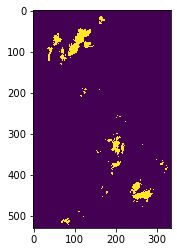

In [5]:
# sanity check cell, used to verify the same 10th percentiles are actually showing up
# (this is also mainly how I tested)

total = geo * 1 + pop * 1 + mway * 1
total /= total.max()
total *= 255

top_perc = np.where(total > np.percentile(np.ravel(total)[np.flatnonzero(total)], 90),1,0)
plt.imshow(top_perc, interpolation='none')